In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('data 2.csv')
# setting to show all columns
pd.set_option('display.max_columns', 500)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
data.shape

(569, 33)

In [4]:
data.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [5]:
data.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [6]:
# number of patients with or without a malignant tumor
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [7]:
data['diagnosis'] = data['diagnosis'].replace({'B': 0, 'M': 1})
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [8]:
# eliminar duplicados
print(len(data))
data = data.drop_duplicates()
print(len(data))

569
569


In [9]:
data = data.drop(columns=['id','Unnamed: 32'])

In [10]:
# outliers
stats = data.describe().transpose()
stats['IQR'] = stats['75%'] - stats['25%']
stats

,count,mean,std,min,25%,50%,75%,max,IQR
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000,4.080000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000,5.630000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000,28.930000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000,362.400000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340,0.018930
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540,0.065480
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680,0.101140
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120,0.053690
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400,0.033800


In [11]:
outliers = pd.DataFrame(columns=data.columns)

for col in stats.index:
    iqr = stats.loc[col,'IQR']
    cutoff = iqr * 3
    lower = stats.loc[col,'25%'] - cutoff
    upper = stats.loc[col,'75%'] + cutoff
    results = data[(data[col] < lower) | (data[col] > upper)]
    outliers = outliers.append(results, sort=False).drop_duplicates()
    
print('Outliers: {:.2f} of the data'.format(len(outliers)/len(data)))
outliers.head()
# to do: esto no es óptimo. si una fila es outlier por más de una variable, se está añadiendo
# tantas veces como variables outliers tenga.
# se soluciona con drop_duplicates pero lo óptimo sería añadirla solo una vez

Outliers: 0.10 of the data


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
212,1,28.11,18.47,188.5,2499.0,0.11420,0.1516,0.3201,0.15950,0.1648,0.05525,2.8730,1.4760,21.980,525.6,0.013450,0.02772,0.06389,0.01407,0.04783,0.004476,28.11,18.47,188.5,2499.0,0.1142,0.1516,0.3201,0.1595,0.1648,0.05525
239,1,17.46,39.28,113.4,920.6,0.09812,0.1298,0.1417,0.08811,0.1809,0.05966,0.5366,0.8561,3.002,49.0,0.004860,0.02785,0.02602,0.01374,0.01226,0.002759,22.51,44.87,141.2,1408.0,0.1365,0.3735,0.3241,0.2066,0.2853,0.08496
82,1,25.22,24.91,171.5,1878.0,0.10630,0.2665,0.3339,0.18450,0.1829,0.06782,0.8973,1.4740,7.382,120.0,0.008166,0.05693,0.05730,0.02030,0.01065,0.005893,30.00,33.62,211.7,2562.0,0.1573,0.6076,0.6476,0.2867,0.2355,0.10510
180,1,27.22,21.87,182.1,2250.0,0.10940,0.1914,0.2871,0.18780,0.1800,0.05770,0.8361,1.4810,5.820,128.7,0.004631,0.02537,0.03109,0.01241,0.01575,0.002747,33.12,32.85,220.8,3216.0,0.1472,0.4034,0.5340,0.2688,0.2856,0.08082
352,1,25.73,17.46,174.2,2010.0,0.11490,0.2363,0.3368,0.19130,0.1956,0.06121,0.9948,0.8509,7.222,153.1,0.006369,0.04243,0.04266,0.01508,0.02335,0.003385,33.13,23.58,229.3,3234.0,0.1530,0.5937,0.6451,0.2756,0.3690,0.08815


In [12]:
# I set cutoff = iqr * 3 because with 1.5 the outliers were 30% of the rows
# with 3 the outliers are 10% of the rows

In [13]:
# outliers removal
print(len(data))
print(len(outliers.index))
data = data[~data.index.isin(outliers.index)]
print(len(data))

569
56
513


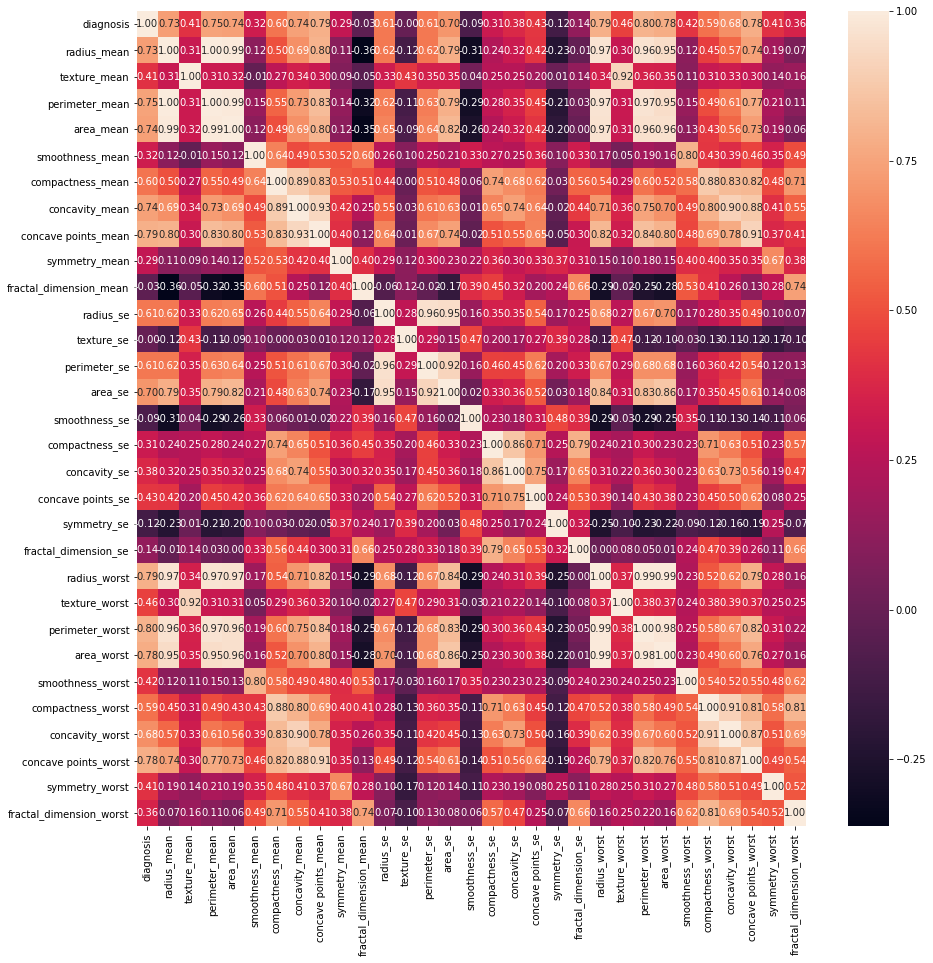

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
# ax.hlines((data.shape[1]-1)*(1/3), (data.shape[1]-1)*(2/3), *ax.get_xlim())
sns.heatmap(data.corr(), fmt='.2f', annot=True)

In [15]:
# vemos que radius, perimeter y area están muy correladas entre ellas, para mean, se y worst, por lo que
# vamos a quitarnos dos de ellas
data = data.drop(columns=['perimeter_mean',
                 'area_mean',
                 'perimeter_se',
                 'area_se',
                 'perimeter_worst',
                 'area_worst'])

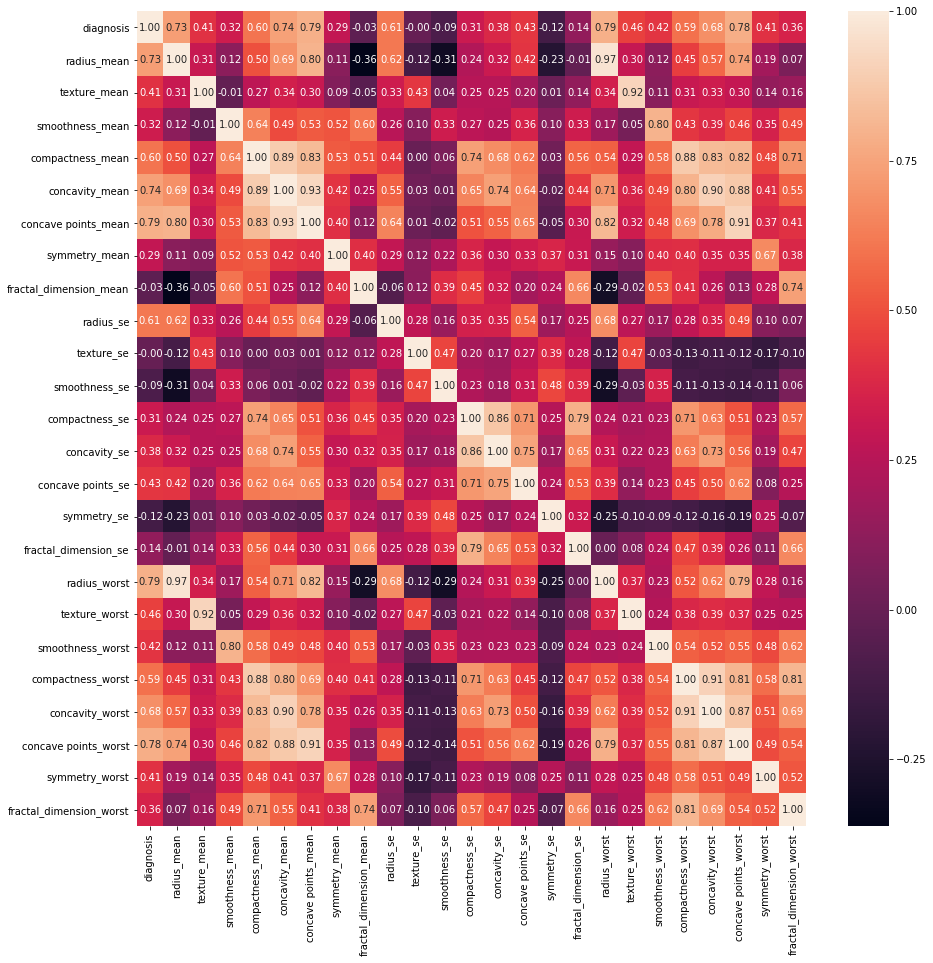

In [16]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), fmt='.2f', annot=True)

In [17]:
# la variable concave_points se podría eliminar en mean y worst porque tienen alta correlación con otras
# variables, pero vamos a eliminarla para se también

In [18]:
data = data.drop(columns=['concave points_mean',
                 'concave points_se',
                 'concave points_worst'])

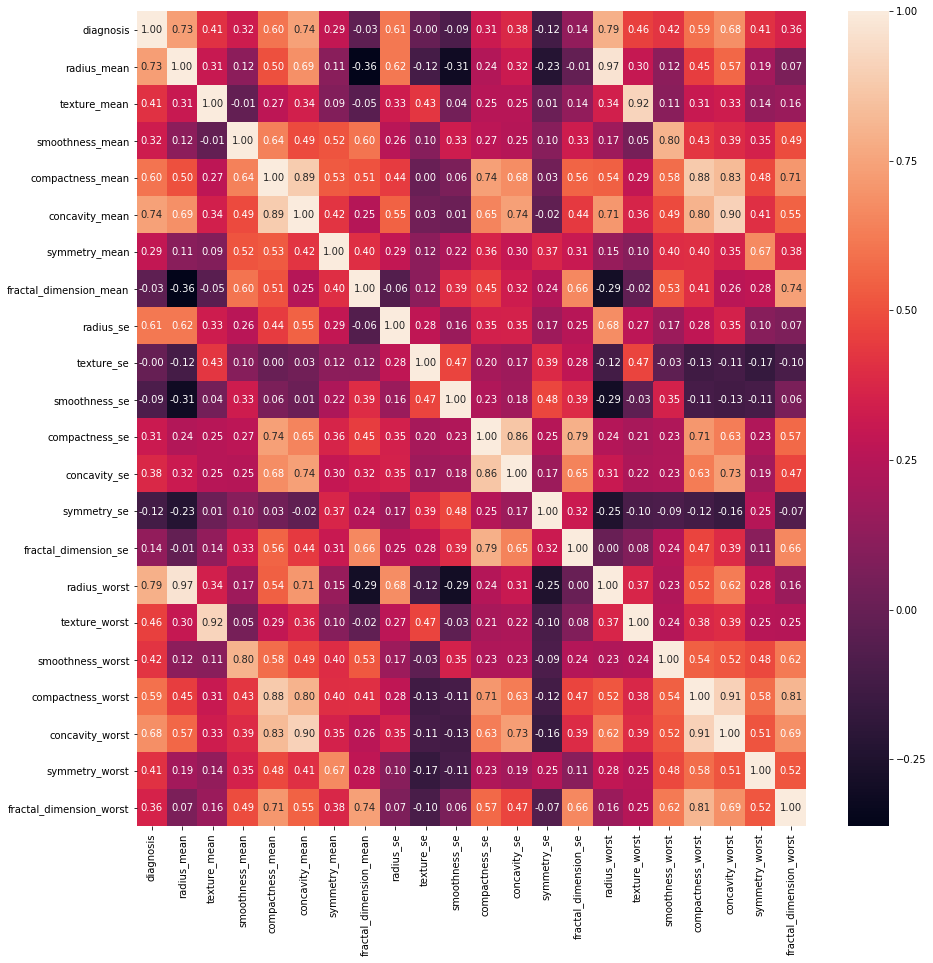

In [19]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), fmt='.2f', annot=True)

In [20]:
data = data.drop(columns=['concavity_mean',
                 'concavity_se',
                 'concavity_worst'])

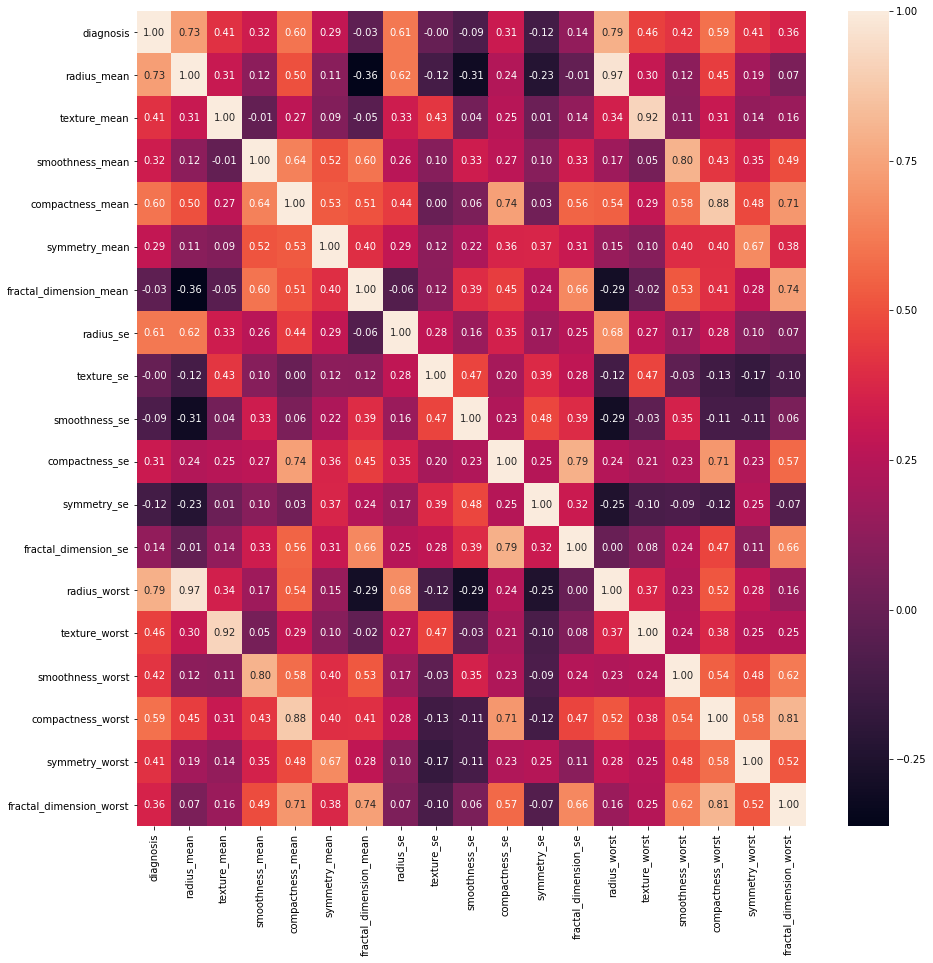

In [21]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), fmt='.2f', annot=True)

In [22]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'smoothness_worst', 'compactness_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')

In [23]:
# vemos que las variables worst tienen mucha correlación con las mismas variables mean, por lo tanto,
# nos quitamos todas las worst
data = data.drop(columns=['radius_worst',
                         'texture_worst',
                         'smoothness_worst',
                         'compactness_worst',
                         'symmetry_worst',
                         'fractal_dimension_worst'])

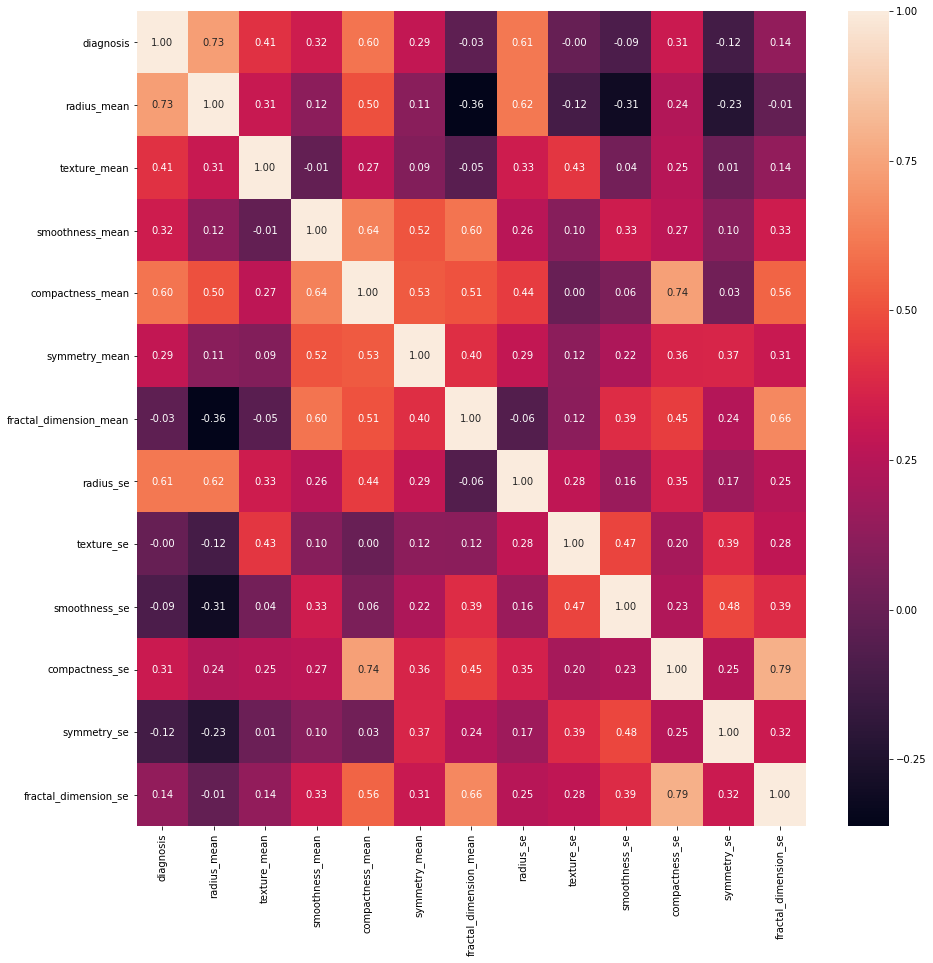

In [24]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), fmt='.2f', annot=True)

In [25]:
# vamos a dividir el dataframe en X e y
X = data.drop(columns='diagnosis')
y = data['diagnosis']
print(X.shape, y.shape)

(513, 12) (513,)


In [26]:
# k-fold cross validation
kfoldcv = [3, 5, 10]

In [27]:
# Logistic Regression
def LRs(X, y, ns):
    cls = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
    scores = cross_val_score(cls, X, y, cv=ns)
    return '{}-Fold Cross Validation - Accuracy: {:.4f} (+/- {:.4f})'.format(ns, scores.mean(), scores.std() * 2)

In [28]:
for ns in kfoldcv:
    print(LRs(X, y, ns))

3-Fold Cross Validation - Accuracy: 0.8968 (+/- 0.0625)
5-Fold Cross Validation - Accuracy: 0.9066 (+/- 0.0664)
10-Fold Cross Validation - Accuracy: 0.9028 (+/- 0.0785)


In [29]:
# Random Forest
def RFs(X, y, n, ns):
    cls = OneVsRestClassifier(RandomForestClassifier(n_estimators=n))
    scores = cross_val_score(cls,X,y,cv=ns)
    return '{}-Fold Cross Validation - Accuracy: {:.4f} (+/- {:.4f})'.format(ns, scores.mean(), scores.std() * 2)

In [30]:
for ns in kfoldcv:
    print(RFs(X, y, 20, ns))

3-Fold Cross Validation - Accuracy: 0.9201 (+/- 0.0475)
5-Fold Cross Validation - Accuracy: 0.9319 (+/- 0.0518)
10-Fold Cross Validation - Accuracy: 0.9359 (+/- 0.0767)


In [31]:
# Support Vector Machines
def SVMs(X, y, ns):
    cls = OneVsRestClassifier(svm.SVC(gamma='auto'))
    scores = cross_val_score(cls, X, y, cv=ns)
    return '{}-Fold Cross Validation - Accuracy: {:.4f} (+/- {:.4f})'.format(ns, scores.mean(), scores.std() * 2)

In [32]:
for ns in kfoldcv:
    print(SVMs(X, y, ns))

3-Fold Cross Validation - Accuracy: 0.9007 (+/- 0.0430)
5-Fold Cross Validation - Accuracy: 0.9006 (+/- 0.0631)
10-Fold Cross Validation - Accuracy: 0.9046 (+/- 0.0840)


In [33]:
# Support Vector Regression
def SVRs(X, y, ns):
    cls = OneVsRestClassifier(svm.SVR(gamma='auto'))
    scores = cross_val_score(cls, X, y, cv=ns)
    return '{}-Fold Cross Validation - Accuracy: {:.4f} (+/- {:.4f})'.format(ns, scores.mean(), scores.std() * 2)

In [34]:
for ns in kfoldcv:
    print(SVRs(X, y, ns))

3-Fold Cross Validation - Accuracy: 0.8987 (+/- 0.0424)
5-Fold Cross Validation - Accuracy: 0.8987 (+/- 0.0656)
10-Fold Cross Validation - Accuracy: 0.9066 (+/- 0.0769)


In [35]:
# k-neighbors
def KNNs(X,y,k,ns):
    cls = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(cls,X,y,cv=ns)
    return '{}-Fold Cross Validation - Accuracy: {:.4f} (+/- {:.4f})'.format(ns, scores.mean(), scores.std() * 2)

In [36]:
for ns in kfoldcv:
    print(KNNs(X, y, 10, ns))

3-Fold Cross Validation - Accuracy: 0.8714 (+/- 0.0494)
5-Fold Cross Validation - Accuracy: 0.8792 (+/- 0.0664)
10-Fold Cross Validation - Accuracy: 0.8775 (+/- 0.0762)


In [37]:
# vamos a probar el modelo Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(410, 12)

(103, 12)

(410,)

(103,)

In [38]:
cls_RandomForestClassifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
cls_RandomForestClassifier.fit(X_train,y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=None)

In [39]:
y_pred = cls_RandomForestClassifier.predict(X_test)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [40]:
predictions = pd.DataFrame(y_test)
predictions['predicted'] = y_pred
predictions.columns = 'actual', 'predicted'
predictions.head()

,actual,predicted
285,0,0
458,0,0
140,0,0
261,1,1
530,0,0


In [41]:
display(predictions['actual'].value_counts())
display(predictions['predicted'].value_counts())

0    71
1    32
Name: actual, dtype: int64

0    75
1    28
Name: predicted, dtype: int64

In [42]:
cm_rf = confusion_matrix(predictions['actual'], predictions['predicted'])
cm_rf

array([[71,  0],
       [ 4, 28]])

In [43]:
# cm con porcentajes
def weighted_confusion_matrix(cm):
    return np.array([cm[i]/sum(cm[i]) for i in range(len(cm))])

In [44]:
print(weighted_confusion_matrix(cm_rf))

[[1.    0.   ]
 [0.125 0.875]]


In [ ]:
# to do:
# probar el modelo sin haber hecho feature selection ni haber eliminado outliers
# grid selection
# pintar confusion matrix
# tests estadísticos para ver qué variables afectan a la variabilidad del modelo
# detectar overfitting